In [1]:
import sys
sys.path.append("../")
import os, os.path as osp
import numpy as np
from collections import namedtuple
import torch
import torch.nn as nn
import torch.functional as F
import cv2
import matplotlib.pyplot as plt

import mcubes
from IPython.core.debugger import set_trace

/home/ayush/projects/nerf/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = 'cuda'
torch.backends.cuda.max_split_size_mb = 256

# Let's define our Nerf Model

This is an overview of the architecture
**Some differences from the paper:**

The authors said that they use 63 size of input by using positional encodings:<br>
<img src = "../assets/nerf-eqn-4.png" width=800>
1. They take x,y,z point origin and encode it with Lpos = 10 <br>
   Pos is x,y,z --> each is encoded 10 times with a sin & cosine value each. so 10* 2* 3.<br>
   Then we also concatenate the actual values of x, y, z <br>
   So input becomes Lpos * 2* 3 + 3 = **63**
2. THey encode every direction x,y,z and encode it with Ldir = 4. <br>
   Hence, the encoding become Ldir * 2 * 3 + 3  = **24**<br>
3. In implementation, they **remove the pi**

<img src = "../assets/nerf-architecture.png" width=800>


In [38]:
class Nerf(nn.Module):
    
    def __init__(self, Lpos=10, Ldir=4, hidden_dim=256, device='cpu'):
        super(Nerf, self).__init__()
        # Pos is x,y,z --> each is encoded 10 times with a sin & cosine value each. so 10* 2* 3
        # Then we also concatenate the actual values of x, y, z
        # So input becomes Lpos * 2* 3 + 3
        self.block1 = nn.Sequential( nn.Linear(Lpos* 2 *3 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    ).to(device)
        self.block2 = nn.Sequential(nn.Linear(hidden_dim + Lpos * 2*3  + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1), nn.ReLU(),  # This last 1 value is added for sigma
                                    ).to(device)
        self.rgb_head = nn.Sequential(nn.Linear(hidden_dim + Ldir * 2* 3 + 3, hidden_dim//2), nn.ReLU(),
                                      nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(),
                                      ).to(device)
        self.Lpos = Lpos
        self.Ldir = Ldir
        self.hidden_dim = hidden_dim
        self.device=device
    
    def positional_encoding(self, xyz, L):
        indxs = torch.arange(L).to(device=self.device)
        indxs = 2 ** indxs
        # indxs = indxs * torch.pi # They mention in the paper, but in implementation, they remove this pi
        base = xyz.unsqueeze(1) * indxs.unsqueeze(-1)
        embed1 = torch.sin(base).reshape(-1, L*3)
        embed2 = torch.cos(base).reshape(-1, L*3)
        pe = torch.cat([embed1, embed2, xyz], dim=1)
        del embed1
        del embed2
        return pe
    
    # def positional_encoding(self, x, L):
    #     out = [x]
    #     for j in range(L):
    #         out.append(torch.sin(2 ** j * x))
    #         out.append(torch.cos(2 ** j * x))
    #     return torch.cat(out, dim=1)
        
    
    def forward(self, xyz_p, xyz_d):
        """
        xyz_p: ray points
        xyz_d: ray_directions
        """
        if xyz_p.device != self.device:
            xyz_p = xyz_p.to(self.device)
        if xyz_d.device != self.device:
            xyz_d = xyz_d.to(self.device)
        B = xyz_p.shape[0] # Batch size
        
        ## getting positional embeddings
        
        x_emb = self.positional_encoding(xyz_p, self.Lpos)   # B, Lpos* 6 + 3
        d_emb = self.positional_encoding(xyz_d, self.Ldir)   # B, Ldir * 6 + 3
        
        # set_trace()
        
        # run the Neural net
        h = self.block1(x_emb) # B, hidden
        h = self.block2(torch.cat([h, x_emb], dim=1))     # B, hidden + 1
        density = h[:,-1]
        h = h[:,:-1]
        colors = self.rgb_head(torch.cat([h, d_emb], dim=1)) # B, 3
        return colors, torch.relu(density)
    
    
    def intersect(self, xyz_p, xyz_d):
        return self.forward(xyz_p, xyz_d)
        
        
        
# nerf = Nerf(Lpos=10, Ldir=4, hidden_dim=256, device=device)

# Inverse rendering

In [5]:
from src.utils.render import render, find_t0_for_image

torch.cuda.empty_cache()

def batchify_image_and_render(model, rays_o, rays_d, tn, tf, num_bins, 
                              reduction_factor=128, device='cpu', 
                              directional_input=True, white_bgr=True):
    npts = rays_o.shape[0]
    assert npts % reduction_factor == 0
    batch_o = rays_o.reshape(-1, npts//reduction_factor, 3)
    batch_d = rays_d.reshape(-1, npts//reduction_factor, 3)
    Ax = np.zeros_like(batch_o)
    for i in range(batch_o.shape[0]):
        Ax[i] = render(model,
                       batch_o[i],
                       batch_d[i], 
                       tn, 
                       tf,
                       num_bins,
                       device,
                       directional_input,
                       white_bgr).detach().cpu()
    return Ax.reshape(-1, 3)
    

# Creating Session

In [6]:
Session = namedtuple('Session', ['sess_dir', 't_started'])

def generate_new_session(root, obj=None):
    from datetime import datetime
    dt = datetime.now()
    dt_str = dt.strftime("%Y-%m-%d %H:%M:%S") # Convert datetime to a string
    if obj is None:
        obj = ""
    sess_dir = osp.join(root, f"exp-{obj}-{dt_str}")
    if not osp.exists(sess_dir):
        os.makedirs(sess_dir, exist_ok=True)
    session = Session(sess_dir, dt)
    return session

def save_model(sess, model, epoch):
    modelpath = osp.join(sess.sess_dir, f"epoch-{epoch}")
    torch.save(model.cpu(), modelpath)

# Train Lego Dataset 100x100

## Load the Lego dataset

In [15]:
from src.utils.dataset.lego_dataset import create_rays

In [42]:
obj = "lego"
H = W = 100
root = f"../data/{obj}"

focal = np.load(osp.join(root, "focal.npy"))
poses = np.load(osp.join(root, "poses.npy"))
imgs = np.load(osp.join(root, "images.npy"))

print(imgs.shape, poses.shape)
o, d, imgt = [], [], []
N = len(imgs)
for i in range(N):
    o_, d_ = create_rays(imgs[i], poses[i], focal)
    o.append(o_)
    d.append(d_)
    imgt.append(imgs[i].reshape(-1, 3))
    
o = np.array(o)
d = np.array(d)
imgt = np.array(imgt)
print("Shapes: ", o.shape, d.shape, imgt.shape)
dataset = np.concatenate([o.reshape(-1, 3), d.reshape(-1, 3), imgt.reshape(-1, 3)], axis=1).astype(np.float32)
dataset.shape, dataset.dtype

(106, 100, 100, 3) (106, 4, 4)
Shapes:  (106, 10000, 3) (106, 10000, 3) (106, 10000, 3)


((1060000, 9), dtype('float32'))

## Training Loop

### Dataloader

In [43]:
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 1024
dataloader_train = DataLoader(torch.from_numpy(dataset).to(device=device), batch_size=batch_size, shuffle=True)

### Define Hyper-parameter

In [44]:

obj = "lego"

## Model Hyper-params
Lpos=10
Ldir=4
hidden_dim=256

## Rendering params
tn = 2.
tf = 6.
num_bins = 100
directional_input = True
white_bgr = True

## Training
num_epochs= 15
warmup_epochs = 1
lr = 1e-3

## TESTING
test_ids  = np.random.randint(low=0, high=N, size=(5,))

### optimization

In [ ]:

loss_history = []

model = Nerf(Lpos=Lpos, Ldir=Ldir, hidden_dim=hidden_dim, device=device)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[5, 10, 15], gamma=0.5)


## START A NEW SESSION
sess = generate_new_session("/home/ayush/projects/nerf/model_checkpoints/og_nerf", obj)


################################## TEST ON SOME IMAGES

def get_mse_and_psnr(gt, pr):
    mse = ((gt - pr)**2).mean()
    psnr = 20 * np.log10(1 / np.sqrt(mse))
    return psnr, mse


def test(session, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, epoch):
    with torch.no_grad():
        for tid in test_ids:
            o_, d_ = create_rays(imgs[tid], poses[tid], focal)
            im  = imgs[tid]
            H, W, _ = im.shape
            Ax = batchify_image_and_render(model=model,
                                   rays_o=o_,
                                   rays_d=d_,
                                   tn=tn,
                                   tf=tf,
                                   num_bins=num_bins,
                                   reduction_factor=16,
                                   device=device,
                                   directional_input=directional_input,
                                   white_bgr=white_bgr)
            Ax = Ax.reshape(H, W, 3)
            psnr, mse = get_mse_and_psnr(im, Ax)
            print(f"Test IDs: {tid}       | PSNR: {psnr: .3f} | MSE :{mse: .3f}")
            Ax = (Ax.reshape(H, W, 3) * 255).astype(np.uint8)
            imdir = osp.join(session.sess_dir, f"epoch_{epoch}")
            if not osp.exists(imdir):
                os.makedirs(imdir)
            impath = osp.join(imdir, f"epoch-{epoch}--image-{tid}.png")
            cv2.imwrite(impath, cv2.cvtColor(Ax, cv2.COLOR_RGB2BGR))

####################  MAIN TRAINING LOOP
    
print("--------------------------------------")
print("\nStarting main process")
for e in range(num_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_train): 
        BS = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render(model, o, d, tn, tf, num_bins, 
                    directional_input=directional_input, device=device,
                   white_bgr=white_bgr)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e}: avg_loss: {avg_loss/ len(dataloader_train)}")
    scheduler.step()
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-epoch{e+1}.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, e)
    


--------------------------------------

Starting main process


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:08<00:00, 15.14it/s]


Epoch: 0: avg_loss: 0.08469538814226403
Test IDs: 85       | PSNR:  16.102 | MSE : 0.025
Test IDs: 46       | PSNR:  8.377 | MSE : 0.145
Test IDs: 16       | PSNR:  11.298 | MSE : 0.074
Test IDs: 97       | PSNR:  12.608 | MSE : 0.055
Test IDs: 93       | PSNR:  9.873 | MSE : 0.103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:09<00:00, 14.89it/s]


Epoch: 1: avg_loss: 0.08348363870215463
Test IDs: 85       | PSNR:  16.102 | MSE : 0.025
Test IDs: 46       | PSNR:  8.377 | MSE : 0.145
Test IDs: 16       | PSNR:  11.298 | MSE : 0.074
Test IDs: 97       | PSNR:  12.608 | MSE : 0.055
Test IDs: 93       | PSNR:  9.873 | MSE : 0.103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:10<00:00, 14.62it/s]


Epoch: 2: avg_loss: 0.083491426479057
Test IDs: 85       | PSNR:  16.102 | MSE : 0.025
Test IDs: 46       | PSNR:  8.377 | MSE : 0.145
Test IDs: 16       | PSNR:  11.298 | MSE : 0.074
Test IDs: 97       | PSNR:  12.608 | MSE : 0.055
Test IDs: 93       | PSNR:  9.873 | MSE : 0.103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:10<00:00, 14.66it/s]


Epoch: 3: avg_loss: 0.08349366111386007
Test IDs: 85       | PSNR:  16.102 | MSE : 0.025
Test IDs: 46       | PSNR:  8.377 | MSE : 0.145
Test IDs: 16       | PSNR:  11.298 | MSE : 0.074
Test IDs: 97       | PSNR:  12.608 | MSE : 0.055
Test IDs: 93       | PSNR:  9.873 | MSE : 0.103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:10<00:00, 14.69it/s]


Epoch: 4: avg_loss: 0.08349376053164595
Test IDs: 85       | PSNR:  16.102 | MSE : 0.025
Test IDs: 46       | PSNR:  8.377 | MSE : 0.145
Test IDs: 16       | PSNR:  11.298 | MSE : 0.074
Test IDs: 97       | PSNR:  12.608 | MSE : 0.055
Test IDs: 93       | PSNR:  9.873 | MSE : 0.103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:09<00:00, 14.93it/s]


Epoch: 5: avg_loss: 0.0835205794286889
Test IDs: 85       | PSNR:  16.102 | MSE : 0.025
Test IDs: 46       | PSNR:  8.377 | MSE : 0.145
Test IDs: 16       | PSNR:  11.298 | MSE : 0.074
Test IDs: 97       | PSNR:  12.608 | MSE : 0.055
Test IDs: 93       | PSNR:  9.873 | MSE : 0.103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:09<00:00, 14.87it/s]


Epoch: 6: avg_loss: 0.08348567665169829
Test IDs: 85       | PSNR:  16.102 | MSE : 0.025
Test IDs: 46       | PSNR:  8.377 | MSE : 0.145
Test IDs: 16       | PSNR:  11.298 | MSE : 0.074
Test IDs: 97       | PSNR:  12.608 | MSE : 0.055
Test IDs: 93       | PSNR:  9.873 | MSE : 0.103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:08<00:00, 15.03it/s]


Epoch: 7: avg_loss: 0.08350084144550171
Test IDs: 85       | PSNR:  16.102 | MSE : 0.025
Test IDs: 46       | PSNR:  8.377 | MSE : 0.145
Test IDs: 16       | PSNR:  11.298 | MSE : 0.074
Test IDs: 97       | PSNR:  12.608 | MSE : 0.055
Test IDs: 93       | PSNR:  9.873 | MSE : 0.103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:09<00:00, 14.81it/s]


Epoch: 8: avg_loss: 0.0834829379160777
Test IDs: 85       | PSNR:  16.102 | MSE : 0.025
Test IDs: 46       | PSNR:  8.377 | MSE : 0.145
Test IDs: 16       | PSNR:  11.298 | MSE : 0.074
Test IDs: 97       | PSNR:  12.608 | MSE : 0.055
Test IDs: 93       | PSNR:  9.873 | MSE : 0.103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:09<00:00, 14.95it/s]


Epoch: 9: avg_loss: 0.04395127027568814
Test IDs: 85       | PSNR:  25.348 | MSE : 0.003
Test IDs: 46       | PSNR:  23.148 | MSE : 0.005
Test IDs: 16       | PSNR:  22.807 | MSE : 0.005
Test IDs: 97       | PSNR:  23.672 | MSE : 0.004
Test IDs: 93       | PSNR:  22.072 | MSE : 0.006


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:08<00:00, 15.12it/s]


Epoch: 10: avg_loss: 0.0043273713888284035
Test IDs: 85       | PSNR:  25.794 | MSE : 0.003
Test IDs: 46       | PSNR:  24.771 | MSE : 0.003
Test IDs: 16       | PSNR:  24.023 | MSE : 0.004
Test IDs: 97       | PSNR:  24.759 | MSE : 0.003
Test IDs: 93       | PSNR:  23.534 | MSE : 0.004


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:09<00:00, 14.95it/s]


Epoch: 11: avg_loss: 0.0035318274825854538
Test IDs: 85       | PSNR:  26.524 | MSE : 0.002
Test IDs: 46       | PSNR:  25.367 | MSE : 0.003
Test IDs: 16       | PSNR:  24.905 | MSE : 0.003
Test IDs: 97       | PSNR:  25.690 | MSE : 0.003
Test IDs: 93       | PSNR:  24.341 | MSE : 0.004


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:09<00:00, 14.96it/s]


Epoch: 12: avg_loss: 0.003069545139206221
Test IDs: 85       | PSNR:  26.013 | MSE : 0.003
Test IDs: 46       | PSNR:  25.873 | MSE : 0.003
Test IDs: 16       | PSNR:  25.519 | MSE : 0.003
Test IDs: 97       | PSNR:  26.348 | MSE : 0.002
Test IDs: 93       | PSNR:  24.803 | MSE : 0.003


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:09<00:00, 14.97it/s]


Epoch: 13: avg_loss: 0.0027982853686762434
Test IDs: 85       | PSNR:  26.929 | MSE : 0.002
Test IDs: 46       | PSNR:  26.478 | MSE : 0.002
Test IDs: 16       | PSNR:  26.043 | MSE : 0.002
Test IDs: 97       | PSNR:  26.694 | MSE : 0.002
Test IDs: 93       | PSNR:  25.358 | MSE : 0.003


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [01:09<00:00, 14.85it/s]


Epoch: 14: avg_loss: 0.002587955043103697
Test IDs: 85       | PSNR:  27.782 | MSE : 0.002
Test IDs: 46       | PSNR:  26.957 | MSE : 0.002
Test IDs: 16       | PSNR:  26.342 | MSE : 0.002
Test IDs: 97       | PSNR:  27.013 | MSE : 0.002
Test IDs: 93       | PSNR:  25.700 | MSE : 0.003


## Test on an image

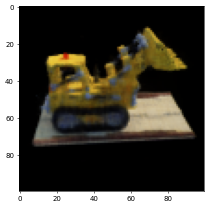

In [60]:
impath = osp.join(sess.sess_dir, "epoch_14", "epoch-14--image-97.png")
im_ = cv2.imread(impath)[...,::-1]
fig = plt.figure(dpi=50)
plt.imshow(im_)

# Train on Fox Dataset



## Load the fox dataset

Moved the dataset to the src package

In [7]:
root = "../assets/fox"

In [18]:
from src.utils.dataset.fox_dataset import make_file_lists, parse_data, create_rays, FoxDataset

fimgs, fposes, fintrinsics= make_file_lists(root, 'train')
imgs, poses, intrinsics = parse_data(fimgs, fposes, fintrinsics)

# small batch experiment
N = len(imgs)
o, d = [], []
for i in range(N):
    o_, d_ = create_rays(imgs[i], poses[i], intrinsics[i])
    o.append(o_)
    d.append(d_)
o = np.array(o)
d = np.array(d)
o.shape, d.shape

(90, 400, 400, 3) (90, 4, 4) (90, 4, 4)


((90, 160000, 3), (90, 160000, 3))

## Training Loop

### Initialize DataLoader

In [19]:
from src.utils.dataset.fox_dataset import FoxDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 1024
dataset_warmup = FoxDataset(imgs, poses, intrinsics, mode='warm-up', device=device)
dataloader_warmup = DataLoader(dataset_warmup, batch_size=batch_size, shuffle=True)

dataset = FoxDataset(imgs, poses, intrinsics, mode='train', device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Center region: Width 100: 300,  Height: 100: 300
Final shapes: O:(3600000, 3), D:(3600000, 3), Imgs:(3600000, 3)
Final concatenated shape: torch.Size([3600000, 9])
Final shapes: O:(90, 160000, 3), D:(90, 160000, 3), Imgs:(90, 400, 400, 3)
Final concatenated shape: torch.Size([14400000, 9])


### Define Hyper-params

In [20]:

obj = "fox"

## Model Hyper-params
Lpos=10
Ldir=4
hidden_dim=256

## Rendering params
tn = 8.
tf = 12.
num_bins = 100
directional_input = True
white_bgr = True

## Training
num_epochs= 15
warmup_epochs = 1
lr = 1e-3

## TESTING
test_ids  = np.random.randint(low=0, high=N, size=(5,))

### Optimization

In [21]:

loss_history = []

model = Nerf(Lpos=Lpos, Ldir=Ldir, hidden_dim=hidden_dim, device=device)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[5, 10, 15], gamma=0.5)


## START A NEW SESSION
sess = generate_new_session("/home/ayush/projects/nerf/model_checkpoints/og_nerf", "fox")


################################## TEST ON SOME IMAGES

def get_mse_and_psnr(gt, pr):
    mse = ((gt - pr)**2).mean()
    psnr = 20 * np.log10(1 / np.sqrt(mse))
    return psnr, mse


def test(session, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, epoch):
    with torch.no_grad():
        for i in test_ids:
            o_, d_ = create_rays(imgs[i], poses[i], intrinsics[i])
            im  = imgs[i]
            H, W, _ = im.shape
            Ax = batchify_image_and_render(model=model,
                                   rays_o=o_,
                                   rays_d=d_,
                                   tn=tn,
                                   tf=tf,
                                   num_bins=num_bins,
                                   reduction_factor=128,
                                   device=device,
                                   directional_input=directional_input,
                                   white_bgr=white_bgr)
            Ax = Ax.reshape(H, W, 3)
            psnr, mse = get_mse_and_psnr(im, Ax)
            print(f"Test IDs: {i}       | PSNR: {psnr: .3f} | MSE :{mse: .3f}")
            Ax = (Ax.reshape(H, W, 3) * 255).astype(np.uint8)
            impath = osp.join(session.sess_dir, f"epoch-{epoch}--image-{i}.png")
            cv2.imwrite(impath, cv2.cvtColor(Ax, cv2.COLOR_RGB2BGR))

            
                    
############################## WARM UP TRAINING : 
##################Train on center part of image (Needed for synthetic dataset  ####################

print("Starting warm-up")
for e in range(warmup_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_warmup):
        N = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render(model, o, d, tn, tf, num_bins, 
                    directional_input=directional_input, device=device,
                   white_bgr=white_bgr)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e}: avg_loss: {avg_loss/ len(dataloader_warmup)}")
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-warmup.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, "warmup")

####################  MAIN TRAINING LOOP
    
print("--------------------------------------")
print("\nStarting main process")
for e in range(num_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader): 
        BS = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render(model, o, d, tn, tf, num_bins, 
                    directional_input=directional_input, device=device,
                   white_bgr=white_bgr)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e}: avg_loss: {avg_loss/ len(dataloader)}")
    scheduler.step()
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-epoch{e+1}.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, e)
    


Starting warm-up


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3516/3516 [03:59<00:00, 14.69it/s]


Epoch: 0: avg_loss: 0.009868894486020047
Test IDs: 40       | PSNR:  28.920 | MSE : 0.001
Test IDs: 67       | PSNR:  28.750 | MSE : 0.001
Test IDs: 57       | PSNR:  27.516 | MSE : 0.002
Test IDs: 52       | PSNR:  27.214 | MSE : 0.002
Test IDs: 44       | PSNR:  28.039 | MSE : 0.002
--------------------------------------

Starting main process


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [15:47<00:00, 14.84it/s]


Epoch: 0: avg_loss: 0.001396822816449611
Test IDs: 40       | PSNR:  31.666 | MSE : 0.001
Test IDs: 67       | PSNR:  29.486 | MSE : 0.001
Test IDs: 57       | PSNR:  30.170 | MSE : 0.001
Test IDs: 52       | PSNR:  30.639 | MSE : 0.001
Test IDs: 44       | PSNR:  31.409 | MSE : 0.001


  6%|██████▎                                                                                            | 903/14063 [01:01<14:59, 14.63it/s]


KeyboardInterrupt: 


### Loss history

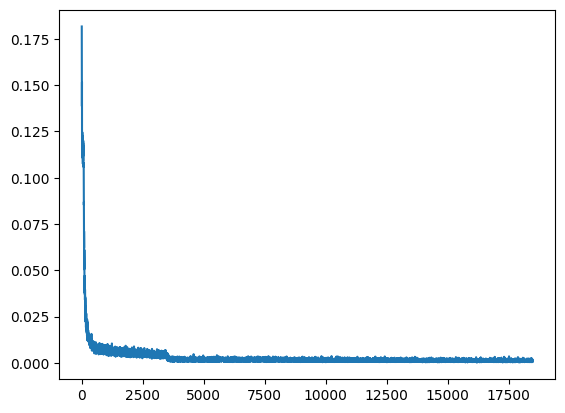

In [22]:
plt.plot(loss_history)

## Let's see output on some train images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


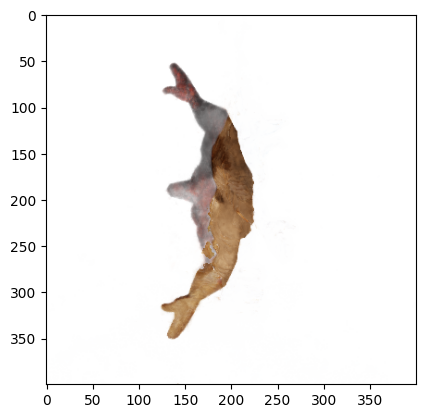

In [13]:
torch.cuda.empty_cache()


img_idx = 0
im = imgs[img_idx]
with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=o[img_idx],
                                   rays_d=d[img_idx],
                                   tn=8.,
                                   tf=12.,
                                   num_bins=100,
                                   reduction_factor=128,
                                   device=device,
                                   white_bgr=True)

plt.imshow(Ax.reshape(400, 400, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


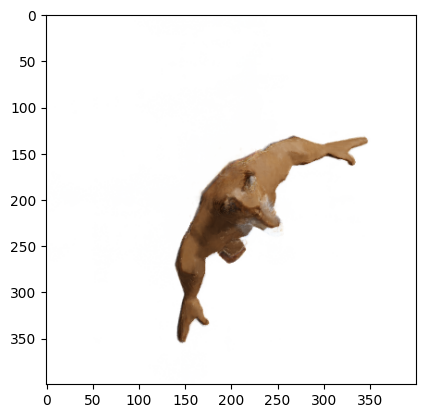

In [14]:
torch.cuda.empty_cache()


img_idx = 1
im = imgs[img_idx]
with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=o[img_idx],
                                   rays_d=d[img_idx],
                                   tn=8.,
                                   tf=12.,
                                   num_bins=100,
                                   reduction_factor=128,
                                   device=device,
                                   white_bgr=True)

plt.imshow(Ax.reshape(400, 400, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


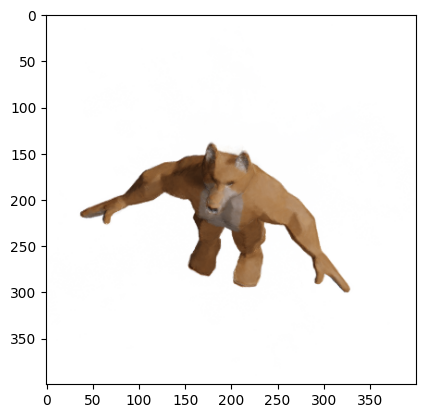

In [15]:
torch.cuda.empty_cache()


img_idx = 2
im = imgs[img_idx]
with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=o[img_idx],
                                   rays_d=d[img_idx],
                                   tn=8.,
                                   tf=12.,
                                   num_bins=100,
                                   reduction_factor=128,
                                   device=device,
                                   white_bgr=True)

plt.imshow(Ax.reshape(400, 400, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


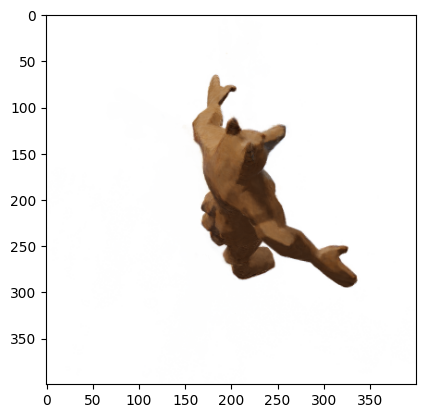

In [16]:
torch.cuda.empty_cache()


img_idx = 3
im = imgs[img_idx]
with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=o[img_idx],
                                   rays_d=d[img_idx],
                                   tn=8.,
                                   tf=12.,
                                   num_bins=100,
                                   reduction_factor=128,
                                   device=device,
                                   white_bgr=True)

plt.imshow(Ax.reshape(400, 400, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


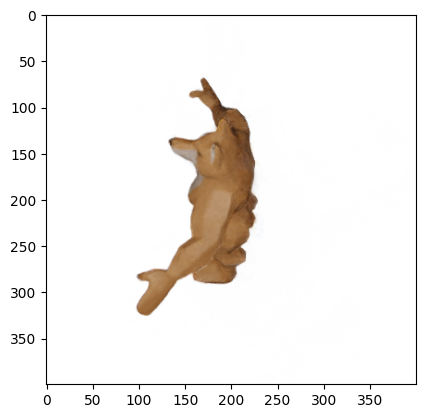

In [17]:
torch.cuda.empty_cache()


img_idx = 4
im = imgs[img_idx]
with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=o[img_idx],
                                   rays_d=d[img_idx],
                                   tn=8.,
                                   tf=12.,
                                   num_bins=100,
                                   reduction_factor=128,
                                   device=device,
                                   white_bgr=True)

plt.imshow(Ax.reshape(400, 400, 3))

## On Test Images

In [23]:
def get_mse_and_psnr(gt, pr):
    mse = ((gt - pr)**2).mean()
    psnr = 20 * np.log10(1 / np.sqrt(mse))
    return psnr, mse

In [24]:
fimgs, fposes, fintrinsics= make_file_lists(root, 'test')
imgs, poses, intrinsics = parse_data(fimgs, fposes, fintrinsics)

# small batch experiment
N = 5
o, d = [], []
for i in range(N):
    o_, d_ = create_rays(imgs[i], poses[i], intrinsics[i])
    o.append(o_)
    d.append(d_)
o = np.array(o)
d = np.array(d)
o.shape, d.shape

(10, 400, 400, 3) (10, 4, 4) (10, 4, 4)


((5, 160000, 3), (5, 160000, 3))

PSNR:  30.395 | MSE : 0.001


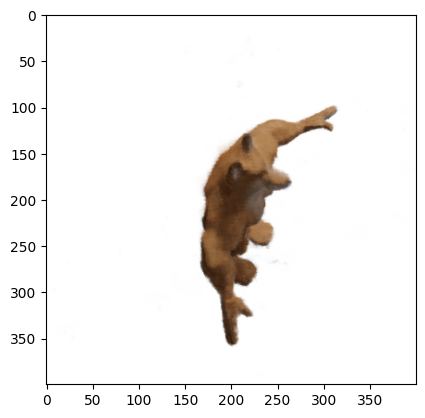

In [25]:
torch.cuda.empty_cache()


img_idx = 0
im = imgs[img_idx]
with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=o[img_idx],
                                   rays_d=d[img_idx],
                                   tn=8.,
                                   tf=12.,
                                   num_bins=100,
                                   reduction_factor=128,
                                   directional_input=True,
                                   device=device,
                                   white_bgr=True)
    psnr, mse = get_mse_and_psnr(im, Ax.reshape(400, 400, 3))
    print(f"PSNR: {psnr: .3f} | MSE :{mse: .3f}")
plt.imshow(Ax.reshape(400, 400, 3))

PSNR:  30.394 | MSE : 0.001


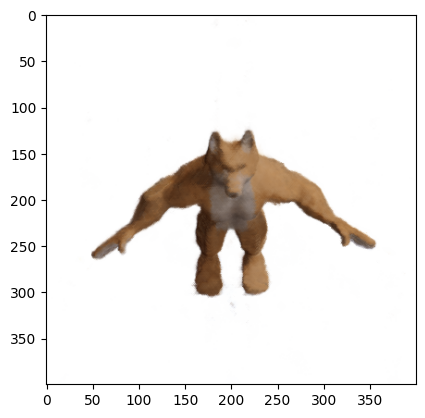

In [26]:
torch.cuda.empty_cache()


img_idx = 1
im = imgs[img_idx]
with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=o[img_idx],
                                   rays_d=d[img_idx],
                                   tn=8.,
                                   tf=12.,
                                   num_bins=100,
                                   reduction_factor=128,
                                   device=device,
                                   white_bgr=True)
    psnr, mse = get_mse_and_psnr(im, Ax.reshape(400, 400, 3))
    print(f"PSNR: {psnr: .3f} | MSE :{mse: .3f}")
plt.imshow(Ax.reshape(400, 400, 3))

PSNR:  31.678 | MSE : 0.001


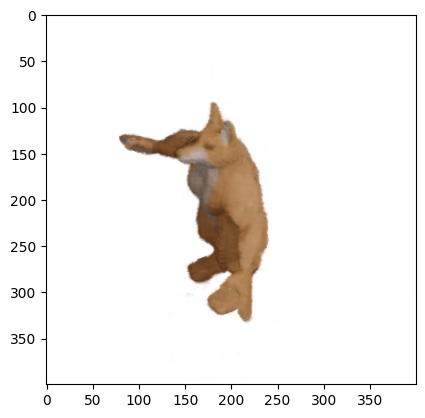

In [28]:
torch.cuda.empty_cache()


img_idx = 2
im = imgs[img_idx]
with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=o[img_idx],
                                   rays_d=d[img_idx],
                                   tn=8.,
                                   tf=12.,
                                   num_bins=100,
                                   reduction_factor=128,
                                   device=device,
                                   white_bgr=True)
    psnr, mse = get_mse_and_psnr(im, Ax.reshape(400, 400, 3))
    print(f"PSNR: {psnr: .3f} | MSE :{mse: .3f}")
plt.imshow(Ax.reshape(400, 400, 3))

PSNR:  31.013 | MSE : 0.001


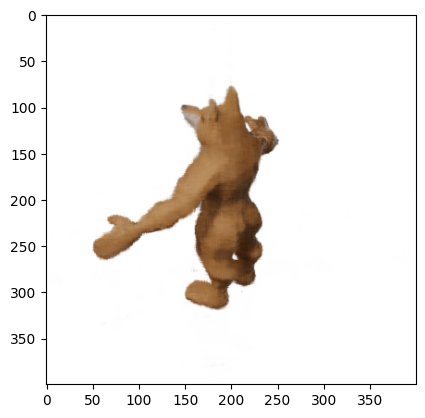

In [29]:
torch.cuda.empty_cache()


img_idx = 3
im = imgs[img_idx]
with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=o[img_idx],
                                   rays_d=d[img_idx],
                                   tn=8.,
                                   tf=12.,
                                   num_bins=100,
                                   reduction_factor=128,
                                   device=device,
                                   white_bgr=True)
    psnr, mse = get_mse_and_psnr(im, Ax.reshape(400, 400, 3))
    print(f"PSNR: {psnr: .3f} | MSE :{mse: .3f}")
plt.imshow(Ax.reshape(400, 400, 3))

# Nerf on LLFF DATASET

## Load the Dataset

In [13]:
root = "/home/ayush/Downloads/datasets/nerf_llff_data"
obj = "room"
resolution = "8" # reduced by factor of 8
poses_file = "poses_bounds.npy"


In [14]:
from src.utils.dataset.llff_dataset import read_files, create_rays, LLFFDataset

data = read_files(root, obj, resolution, poses_file)
imgs, poses, imats, metas = data[obj]
print(imgs.shape, poses.shape, imats.shape, metas.shape)

for i in range(len(imgs)):
    o_, d_ = create_rays(imgs[i], poses[i], imats[i], metas[i])
    _, find_t0_for_image(o_, d_)
    break

(41, 378, 504, 3) (41, 4, 4) (41, 4, 4) (41, 2)
Tx:: m:  30.107  | M:  86.644  | mu:  48.637
Ty:: m: -7623296.283  | M:  8189568.290  | mu:  40.140
Tz:: m: -0.177  | M: -0.172  | mu: -0.174
T:: m: -7623296.283  | M:  8189568.290  | mu:  29.534


## Training Loop

### Initialize Dataloader

In [ ]:
from src.utils.dataset.llff_dataset import LLFFDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 1024
dataset_warmup = LLFFDataset(imgs, poses, imats, metas, mode='warm-up', device=device)
dataloader_warmup = DataLoader(dataset_warmup, batch_size=batch_size, shuffle=True)

dataset = LLFFDataset(imgs, poses, imats, metas, mode='train', device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Define Hyper-parameter

In [ ]:

obj = "horns"

## Model Hyper-params
Lpos=10
Ldir=4
hidden_dim=256

## Rendering params
tn = 8.
tf = 12.
num_bins = 100
directional_input = True
white_bgr = True

## Training
num_epochs= 15
warmup_epochs = 1
lr = 1e-3

## TESTING
test_ids  = np.random.randint(low=0, high=N, size=(5,))

### Optimization

In [6]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from src.utils.dataset.llff_dataset import read_files, create_rays, LLFFDataset

In [7]:
root = "/home/ayush/Downloads/datasets/nerf_llff_data"
obj = "horns"
resolution = "8" # reduced by factor of 8
poses_file = "poses_bounds.npy"


In [8]:
data = read_files(root, obj, resolution, poses_file)
imgs, poses, imats, metas = data[obj]
imgs.shape, poses.shape, imats.shape, metas.shape

((62, 378, 504, 3), (62, 4, 4), (62, 4, 4), (62, 2))

In [14]:
batch_size = 1024
dataset_warmup = LLFFDataset(imgs, poses, imats, metas, mode='warm-up', device=device)
dataloader_warmup = DataLoader(dataset_warmup, batch_size=batch_size, shuffle=True)

dataset = LLFFDataset(imgs, poses, imats, metas, mode='train', device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 58.29it/s]


Center region: Width 126: 378,  Height: 94: 283
Final shapes: O:(2452968, 3), D:(2452968, 3), Imgs:(2452968, 3)
Final concatenated shape: torch.Size([2452968, 9])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 61.99it/s]


Final shapes: O:(62, 190512, 3), D:(62, 190512, 3), Imgs:(62, 378, 504, 3)
Final concatenated shape: torch.Size([11811744, 9])


## Let's reload the Nerf Model

In [15]:
num_epochs= 15
warmup_epochs = 1
tn = 8
tf = 12
num_bins = 100
lr = 1e-3

loss_history = []
model = Nerf(Lpos=10, Ldir=4, hidden_dim=256, device=device)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[5, 10, 15], gamma=0.5)

print("Starting warm-up")
for e in range(warmup_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_warmup):
        N = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render(model, o, d, tn, tf, num_bins, device=device, white_bgr=False)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e+1}: avg_loss: {avg_loss/ len(dataloader_warmup)}")

print("--------------------------------------")
print("\nStarting main process")
for e in range(num_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader): 
        # progress_bar = tqdm(dataloader, desc=f"Epoch {e+1}/{num_epochs}  | batch: {idx}")
        N = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render(model, o, d, tn, tf, num_bins, device=device, white_bgr=False)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e+1}: avg_loss: {avg_loss/ len(dataloader)}")
    
        
    scheduler.step()
    torch.save(model.cpu(), 'model_nerf.pth')
    model.to(device)
    


Starting warm-up


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2396/2396 [03:11<00:00, 12.54it/s]


Epoch: 1: avg_loss: 0.02013780859428052
--------------------------------------

Starting main process


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:22<00:00, 12.50it/s]


Epoch: 1: avg_loss: 0.016465138500830055


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:13<00:00, 12.63it/s]


Epoch: 2: avg_loss: 0.011362335030804943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:15<00:00, 12.60it/s]


Epoch: 3: avg_loss: 0.01018031442858437


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:13<00:00, 12.62it/s]


Epoch: 4: avg_loss: 0.009542797719490544


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:18<00:00, 12.57it/s]


Epoch: 5: avg_loss: 0.009120373354799234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:19<00:00, 12.55it/s]


Epoch: 6: avg_loss: 0.007319538680837366


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:32<00:00, 12.37it/s]


Epoch: 7: avg_loss: 0.006863650277347393


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:19<00:00, 12.54it/s]


Epoch: 8: avg_loss: 0.006650089710550386


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:30<00:00, 12.40it/s]


Epoch: 9: avg_loss: 0.00650535167376969


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:21<00:00, 12.52it/s]


Epoch: 10: avg_loss: 0.006392796669400806


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [15:19<00:00, 12.54it/s]


Epoch: 11: avg_loss: 0.005496224397805523


 14%|██████████████▏                                                                                    | 1656/11535 [02:12<13:11, 12.48it/s]


KeyboardInterrupt: 

## Let's see output on some images

In [17]:
from src.utils.render import batchify_image_and_render
from src.utils.dataset.llff_dataset import read_files, create_rays, LLFFDataset

root = "/home/ayush/Downloads/datasets/nerf_llff_data"
obj = "horns"
resolution = "8" # reduced by factor of 8
poses_file = "poses_bounds.npy"

data = read_files(root, obj, resolution, poses_file)
imgs, poses, imats, metas = data[obj]
imgs.shape, poses.shape, imats.shape, metas.shape

((62, 378, 504, 3), (62, 4, 4), (62, 4, 4), (62, 2))

In [18]:
# small batch experiment

N = 5
o, d = [], []
for i in range(N):
    o_, d_ = create_rays(imgs[i], poses[i], imats[i], metas[i])
    o.append(o_)
    d.append(d_)
o = np.array(o)
d = np.array(d)
o.shape, d.shape

((5, 190512, 3), (5, 190512, 3))

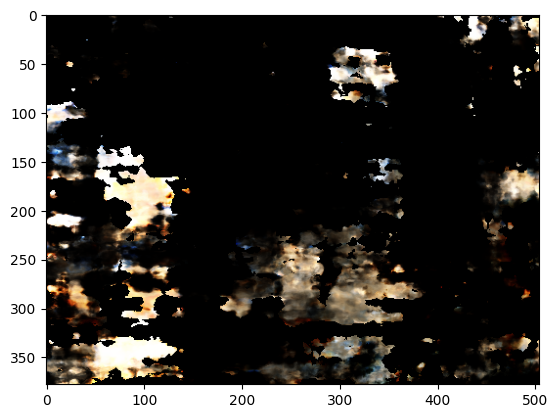

In [21]:
torch.cuda.empty_cache()

img_idx = 3
im = imgs[img_idx]
H, W = metas[img_idx]
with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=o[img_idx],
                                   rays_d=d[img_idx],
                                   tn=8.,
                                   tf=12.,
                                   num_bins=100,
                                   reduction_factor=16,
                                   device=device,
                                   directional_input=True,
                                   white_bgr=False)

plt.imshow(Ax.reshape(H, W, 3))